# Notebook for image colorization

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from skimage import io
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from scipy.spatial import distance
from scipy import spatial

In [33]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Reshape
from keras.layers import Softmax
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [34]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### Extract class birds from test and train dataset

In [35]:
train_set=np.empty([0, 3072], dtype=np.uint8)
file_list=['data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5']
for i in file_list:
    filepath='../data/'+i
    batch=unpickle(filepath)
    # select bird image data
    a=np.array(batch[b'labels'])==2
    b=batch[b'data']
    b=b[a,:]
    # add to training set
    train_set=np.concatenate((train_set, b))
    
test_batch=unpickle('../data/test_batch')
a=np.array(test_batch[b'labels'])==2
b=test_batch[b'data']
b=b[a,:]
test_set=b

In [56]:
train_set

array([[164, 105, 118, ...,  29,  26,  44],
       [ 17,  17,  17, ...,  20,  18,  16],
       [197, 198, 201, ...,  61,  63,  57],
       ...,
       [ 84,  79,  87, ...,  31,  54,  53],
       [188, 186, 187, ..., 186, 171, 170],
       [145, 151, 156, ...,  56,  53,  54]], dtype=uint8)

In [57]:
test_set

array([[100,  68, 116, ...,  68,  94, 100],
       [ 66,  66,  64, ..., 146, 145, 144],
       [201, 187, 146, ...,  28,  21,  11],
       ...,
       [ 73,  67,  62, ..., 144, 148, 151],
       [ 49,   8,   7, ...,  86,  52,  63],
       [136, 136, 125, ...,  95,  98,  98]], dtype=uint8)

### Choose 90% of the pixels randomly

In [36]:
# determine the number of pixels to choose
data=np.concatenate((train_set, test_set))
total_pixel=6000*32*32
percent=0.9
num_pixel=(int)(percent*total_pixel)

In [37]:
# generate random RGB index and image index
R_idx=np.random.randint(0, high=1024, size=num_pixel, dtype=np.int)
img_idx=np.random.randint(0, high=6000, size=num_pixel, dtype=np.int)
pixel=[]

In [38]:
# add pixel vectors to list
for i in range(0,num_pixel):
    img=img_idx[i]
    R=data[img][R_idx[i]]
    G=data[img][R_idx[i]+1024]
    B=data[img][R_idx[i]+2048]
    pixel.append([R,G,B])

In [152]:
pixel.shape

(5529600, 3)

In [39]:
# run k-means clustering
pixel=np.array(pixel)
kmeans=KMeans(n_clusters=4, random_state=0).fit(pixel)

In [40]:
tetrachrome=np.empty([6000,3072], dtype=np.uint8)

In [42]:
main=kmeans.cluster_centers_
for i in range (0,6000):
    for j in range(0,1024):
        R=data[i][j]
        G=data[i][j+1024]
        B=data[i][j+2048]
        pt=main[spatial.KDTree(main).query([R,G,B])[1]]
        tetrachrome[i][j]=pt[0]
        tetrachrome[i][j+1024]=pt[1]
        tetrachrome[i][j+2048]=pt[2]

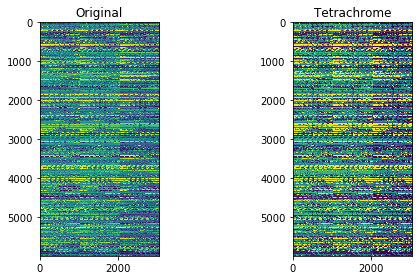

In [43]:
# display tetrachrome RGB value
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(data)
ax[0].set_title("Original")
ax[1].imshow(tetrachrome)
ax[1].set_title("Tetrachrome")

fig.tight_layout()
plt.show()

### Obtain grayscale images

In [44]:
# convert data to 3D array
img=np.empty([6000,1024,3], dtype=np.uint8)
for i in range(0,6000):
    for j in range(0,1024):
        img[i][j][0]=data[i][j]
        img[i][j][1]=data[i][j+1024]
        img[i][j][2]=data[i][j+2048]

In [45]:
# convert to grayscale
grayscale=rgb2gray(img)
grayscale

array([[0.73834824, 0.49751608, 0.54210314, ..., 0.46246863, 0.4563149 ,
        0.59104078],
       [0.02314863, 0.02314863, 0.02006039, ..., 0.11140314, 0.10356   ,
        0.09571686],
       [0.74194941, 0.74587098, 0.75763569, ..., 0.29507608, 0.29761373,
        0.26430667],
       ...,
       [0.38337961, 0.36574392, 0.35511804, ..., 0.73745333, 0.75230627,
        0.76407098],
       [0.16125255, 0.02800157, 0.02745098, ..., 0.50689137, 0.41344588,
        0.42405608],
       [0.55988667, 0.58683255, 0.55100275, ..., 0.65904353, 0.66436392,
        0.6607251 ]])

In [46]:
grayscale.shape

(6000, 1024)

In [50]:
# reshape grayscale to (5000, 32, 32, 1) as train X
temp=grayscale[0:5000]
train_X=np.reshape(temp, (5000, 32, 32, 1))

In [84]:
# get test_X
test_temp=grayscale[5000:]
test_X=np.reshape(test_temp, (1000, 32, 32, 1))

In [70]:
# reshape tetrachrome to (5000, 32, 32, 4) as train Y
train_Y=np.empty([5000,32,32,4], dtype=np.uint8)
for i in range(0,5000):
    for j in range(0,1024):
        R=tetrachrome[i][j]
        G=tetrachrome[i][j+1024]
        B=tetrachrome[i][j+2048]
        if R==207:
            label=[1,0,0,0]
        elif R==109:
            label=[0,1,0,0]
        elif R==156:
            label=[0,0,1,0]
        else:
            label=[0,0,0,1]
        row=(int)(j/32)
        col=j%32
        train_Y[i][row][col]=label

In [86]:
# get test_Y
test_Y=np.empty([1000,32,32,4], dtype=np.uint8)
for i in range(5000,6000):
    for j in range(0,1024):
        R=tetrachrome[i][j]
        G=tetrachrome[i][j+1024]
        B=tetrachrome[i][j+2048]
        if R==207:
            label=[1,0,0,0]
        elif R==109:
            label=[0,1,0,0]
        elif R==156:
            label=[0,0,1,0]
        else:
            label=[0,0,0,1]
        row=(int)(j/32)
        col=j%32
        test_Y[i-5000][row][col]=label

In [79]:
epochs=30
batch_size=100

In [26]:
# stack layers
model=Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(32,32,1), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(Dense(4096, activation='linear'))
model.add(Reshape((32, 32, 4)))
model.add(Softmax(axis=-1))

In [78]:
# compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        832       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               524416    
_________________________________________________________________
dense_12 (Dense)             (None, 4096)            

In [87]:
train = model.fit(train_X, train_Y, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(test_X, test_Y))

Train on 5000 samples, validate on 1000 samples
Epoch 1/30
5000/5000 [==============================] - 19s 4ms/step - loss: 0.5471 - accuracy: 0.7685 - val_loss: 0.6120 - val_accuracy: 0.7386
Epoch 2/30
5000/5000 [==============================] - 19s 4ms/step - loss: 0.5435 - accuracy: 0.7696 - val_loss: 0.6094 - val_accuracy: 0.7385
Epoch 3/30
5000/5000 [==============================] - 19s 4ms/step - loss: 0.5395 - accuracy: 0.7713 - val_loss: 0.6024 - val_accuracy: 0.7431
Epoch 4/30
5000/5000 [==============================] - 18s 4ms/step - loss: 0.5321 - accuracy: 0.7749 - val_loss: 0.6063 - val_accuracy: 0.7415
Epoch 5/30
5000/5000 [==============================] - 18s 4ms/step - loss: 0.5297 - accuracy: 0.7758 - val_loss: 0.6070 - val_accuracy: 0.7386
Epoch 6/30
5000/5000 [==============================] - 20s 4ms/step - loss: 0.5294 - accuracy: 0.7758 - val_loss: 0.6013 - val_accuracy: 0.7434
Epoch 7/30
5000/5000 [==============================] - 19s 4ms/step - loss: 0.521

In [88]:
loss=train.history['loss']
val_loss=train.history['val_loss']
epoch_val=range(len(loss))

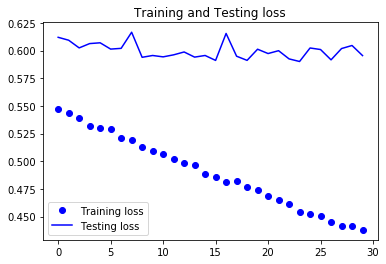

In [89]:
plt.plot(epoch_val, loss, 'bo', label='Training loss')
plt.plot(epoch_val, val_loss, 'b', label='Testing loss')
plt.title('Training and Testing loss')
plt.legend()
plt.show()

In [91]:
test_eval=model.evaluate(test_X, test_Y, verbose=1)
train_eval=model.evaluate(train_X, train_Y, verbose=1)

5000/5000 [==============================] - 6s 1ms/step


In [92]:
print('Test loss:', test_eval[0])
print('Train loss:', train_eval[0])

Test loss: 0.5954885730743408
Train loss: 0.4181122992992401


In [96]:
test_pred=model.predict(test_X[0:10])

In [118]:
test_pred1=np.empty([10,32,32,3])
for i in range(0,10):
    for row in range(0,32):
        for col in range(0,32):
            label=test_pred[i][row][col]
            result=np.where(label==np.amax(label))
            index=result[0][0]
            RGB=main[index]
            test_pred1[i][row][col]=RGB

In [130]:
test_true_temp=tetrachrome[5000:5010]
test_true=np.empty([10,32,32,3])
for i in range(0,10):
    for j in range(0,1024):
        R=test_true_temp[i][j]
        G=test_true_temp[i][j+1024]
        B=test_true_temp[i][j+2048]
        row=(int)(j/32)
        col=j%32
        test_true[i][row][col]=[R,G,B]

In [147]:
real_img_temp=data[5000:]
real_img=np.empty([10,32,32,3])
for i in range(0,10):
    for j in range(0,1024):
        R=real_img_temp[i][j]
        G=real_img_temp[i][j+1024]
        B=real_img_temp[i][j+2048]
        row=(int)(j/32)
        col=j%32
        real_img[i][row][col]=[R,G,B]

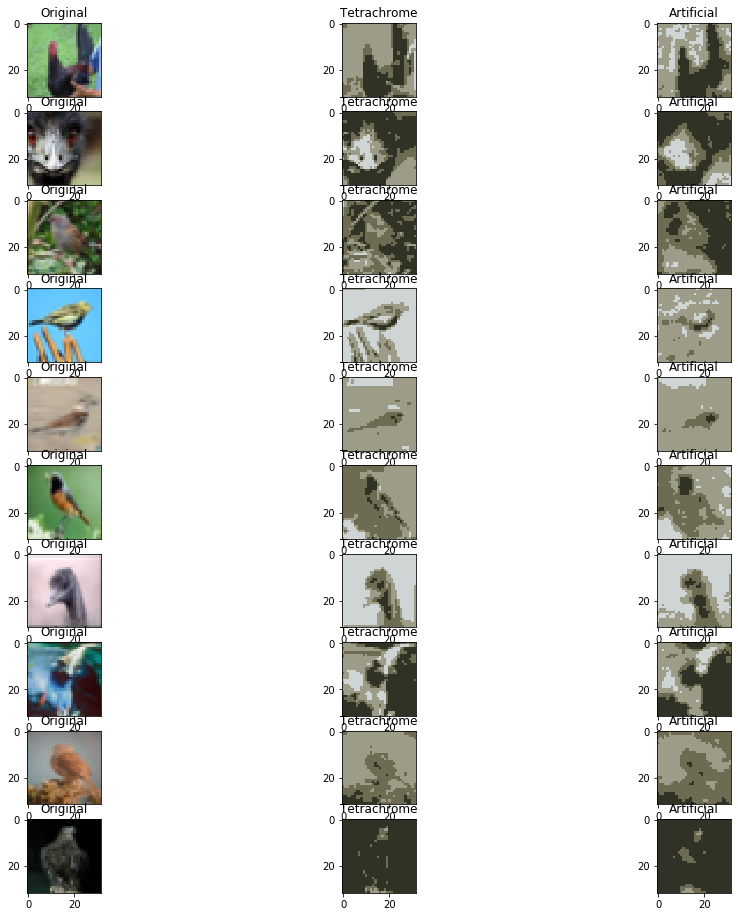

In [151]:
test_pred1=np.uint8(test_pred1)
test_true=np.uint8(test_true)
real_img=np.uint8(real_img)

# display original tetrachrome image and artificial image
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(16, 16))
for i in range(0,10):
    axes[i, 0].imshow(real_img[i])
    axes[i, 0].set_title("Original")
    axes[i, 1].imshow(test_true[i])
    axes[i, 1].set_title("Tetrachrome")
    axes[i, 2].imshow(test_pred1[i])
    axes[i, 2].set_title("Artificial")
plt.show()